# [Easy21](https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf) solution

In [1]:
from enum import Enum
import logging
import random

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

## Environment

In [2]:
from enum import Enum

class Action(Enum):
    STICK = 0
    HIT = 1
 
class Card(object):   
    def __init__(self, color, value):
        self.color = color
        self.value = value
        
    def __str__(self):
        return "Card: {} {}".format(self.color, self.value)
  
class Color(Enum):
    RED = 0
    BLACK = 1

class Reward(object):
    LOSS = -1
    DRAW = 0
    WIN = 1

class State(object):
    def __init__(self,
                 dealer_first_card=None,
                 player_sum=None,
                 is_terminal=False):
        self.dealer_first_card = dealer_first_card
        self.player_sum = player_sum
        self.is_terminal = is_terminal
    
    def __str__(self):
        return ("State:\n\tDealer's first card: {}\n\t"
                "Player sum: {}\n\t"
                "Is terminal: {}\n".format(
            str(self.dealer_first_card),
            self.player_sum,
            self.is_terminal
        ))

In [11]:
BUST_LOWER_BOUND = 1
BUST_UPPER_BOUND = 21
# The dealer sticks on any sum of 17 or greater and hits otherwise.
DEALER_STICK_VALUE = 17

DEALER_RANGE = range(1, 11)
PLAYER_RANGE = range(1, 22)
STATE_SPACE_DIM = (len(DEALER_RANGE), len(PLAYER_RANGE), 2)

def draw_card(v = None, c = None):
  """Returns a card from an infinite deck of cards.
  
  Each draw results in a value between 1 and 10 (uniformly distributed)
  with a color of red (p = 1/3) or black (p = 2/3).
  
  Args:
      v: A pre-determined value.
      c: A pre-determined color.
  """
  value = v or random.randint(1, 10)
  color = c or (Color.RED if random.random() < 1/3 else Color.BLACK)
  
  return Card(color=color, value=value)

def get_random_action():
    p = random.random()
    return Action.STICK.value if p < .5 else Action.HIT.value

def is_busted(deck_sum):
  return (deck_sum > BUST_UPPER_BOUND or deck_sum < BUST_LOWER_BOUND)

def update_sum(cur_sum, card):  
  card_value = card.value if card.color == Color.BLACK \
                          else -1 * card.value
  return cur_sum + card_value

class Environment(object):
  def __init__(self):
    self.cur_state = None
    self.reset()

  def reset(self):
    # Player starts with a black card.
    player_first_card = draw_card(c=Color.BLACK)
    # Dealer starts with a black card.
    dealer_first_card = draw_card(c=Color.BLACK)
    self.cur_state = State(dealer_first_card=dealer_first_card,
      player_sum = player_first_card.value,
      is_terminal=False)
    return self.cur_state

  def step(self, a):
    # If the player hits...
    if a == Action.HIT:
      # She draws another card from the deck.
      card = draw_card()

      # The value of the player's cards are totaled.
      player_sum = update_sum(self.cur_state.player_sum, card)

      # Update the next state.
      next_state = State(dealer_first_card = self.cur_state.dealer_first_card,
player_sum = player_sum, is_terminal=is_busted(player_sum)) 
      r = Reward.LOSS if next_state.is_terminal else 0 

    # If the player sticks...
    else:
      # She receives no further cards.
      player_sum = self.cur_state.player_sum
      
      # The dealer starts taking turns.
      dealer_sum = self.cur_state.dealer_first_card.value
      while (dealer_sum < DEALER_STICK_VALUE and \
                  not(is_busted(dealer_sum))):
        # Dealer hits.
        card = draw_card()
        dealer_sum = update_sum(dealer_sum, card)
             
      next_state = State(is_terminal=True)

      if is_busted(dealer_sum):
          r = Reward.WIN
      elif player_sum == dealer_sum:
          r = Reward.DRAW
      else:
          r = Reward.WIN if player_sum > dealer_sum \
              else Reward.LOSS
      
    self.cur_state = next_state
    return (next_state, r)

In [17]:
# Add baselines and wrappers to play the game.
def strategy_always_hit(s):
    return Action.HIT

def strategy_always_stick(s):
    return Action.STICK

def strategy_dealer_mirror(s):
    """This strategy also sticks at 17+."""
    if s.player_sum >= 17:
        return Action.STICK
    return Action.HIT

def run_episodes(get_action_fn, eval_episode_fn=None, n_episodes=100):
    episodes = []
    for i in range(n_episodes):
        episodes.append(run_episode(get_action_fn, eval_episode_fn))
        
    rs = [e[-1][-1] for e in episodes]
    print("Average score: {} ({}/{})".format(sum(rs)/len(rs), sum(rs), len(rs)))
    print("\tWins: {}".format(sum([1 for r in rs if r == 1])))
    print("\tDraws: {}".format(sum([1 for r in rs if r == 0])))
    print("\tLosses: {}".format(sum([1 for r in rs if r == -1])))
    
    # Plot graph over episodes.
    rolling_n = round(n_episodes/100)
    ax = pd.Series(rs).rolling(rolling_n).mean()[rolling_n - 1:].plot(
        title=get_action_fn.__name__)
    ax.set_xlabel("episodes")
    ax.set_ylabel("score")
    
    # Add a trendline.
    x = [x for x in range(len(rs))]
    z = np.polyfit(x, rs, 6)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--")
    
    return episodes 

def run_episode(get_action_fn, eval_episode_fn):
    env = Environment()
    s = env.reset()
    episode = []
    while (not s.is_terminal):
        action = get_action_fn(s)
        ns, reward = env.step(action)
        episode.append([s, action, reward])
        s = ns
        
    if eval_episode_fn:
        eval_episode_fn(episode)
        
    return episode

episodes = run_episodes(strategy_dealer_mirror, n_episodes=1000)

Average score: -0.231 (-231/1000)
	Wins: 362
	Draws: 45
	Losses: 593


NameError: name 'strategy' is not defined

## Monte-Carlo control

In [5]:
# Monte-Carlo policy evaluation Q = q_\pi   
class MonteCarloControl(object):
    N_INIT = 100
    
    def __init__(self):
        self.N = np.zeros(STATE_SPACE_DIM)
        self.Q = np.zeros(STATE_SPACE_DIM)
    
    def get_epsilon(self, s):
        # Number of times this space has been visited.
        n_s = np.sum(self.N[s.dealer_first_card.value - 1, s.player_sum - 1, :])
        return MonteCarloControl.N_INIT / (
            MonteCarloControl.N_INIT + n_s)
    
    def evaluate_episode(self, episode):
        """Monte-Carlo policy evaluation."""
        # is.gd/kZpF7y
        for state, action, reward in episode:
            dealer_first_card = state.dealer_first_card.value
            player_sum = state.player_sum
            key = (dealer_first_card - 1, player_sum - 1, action)
            
            # N(S_t, A_t) <- N(S_t, A_t) + 1
            self.N[key] += 1
            
            # Q(s) <- Q(s) + /frac{1}{N(S_t, A_t)}(G_t - Q(S_t, A_t))
            alpha = 1.0 / self.N[key]
            self.Q[key] +=  alpha * (reward - self.Q[key])
            
        return
    
    def get_greedy_action(self, s):
        return np.argmax(self.Q[s.dealer_first_card.value - 1, s.player_sum - 1, :])
    
    def glie_mc_control(self, s):
        """Returns the action to take."""
        epsilon = self.get_epsilon(s)
        p = random.random()
        # With probability epsilon, choose an action at random.
        if p < epsilon:
            return get_random_action()
        # With probability 1 - epsilon, choose the greedy action.
        else:
            return self.get_greedy_action(s)

In [6]:
def plot_3d(Q):
    V = np.max(Q, axis=2)
    X, Y = np.mgrid[DEALER_RANGE, PLAYER_RANGE]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    plt.title("V*")
    plt.xlabel("Dealer Initial Card")
    plt.ylabel("Player Sum")
    ax.plot_surface(X, Y, V, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)

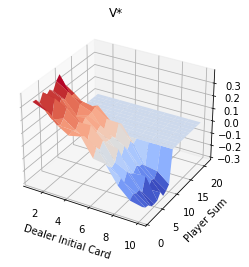

In [12]:
mc = MonteCarloControl()
episodes = run_episodes(mc.glie_mc_control, mc.evaluate_episode, 100000)
plot_3d(mc.Q)

## Tests

In [3]:
# Verify draw distributions.
numbers = [0] * 10
colors = [0] * 2

for i in range(100000):
    card = draw()
    # Expected to be uniform.
    numbers[card.value - 1] += 1
    
    # Expected to be 1/3, 2/3.
    colors[card.color.value] += 1
    
print(numbers)
print(colors)

[10063, 9849, 10006, 9918, 10001, 10018, 10037, 10077, 10020, 10011]
[33536, 66464]


In [4]:
# Verify Round.get_deck_sum() 
cards = [Card(Color.BLACK, 1), Card(Color.RED, 4), Card(Color.BLACK, 3)]
# Expected 0 (1 + 3 - 4)
print(Round.get_deck_sum(cards))

# Verify is_busted().
cards = [Card(Color.BLACK, 23), Card(Color.RED, 4), Card(Color.BLACK, 3)]
s = sum([c.value for c in cards])
print(Round.is_busted(s))

0
True


Average score: -0.2768


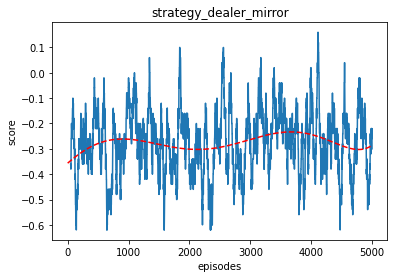